# <font color='red'><ins>Práctica 2 FAA - Vecinos próximos & Regresión Logística</ins></font>
## Alejandro Santorum Varela - alejandro.santorum@estudiante.uam.es
## José Manuel Chacón Aguilera - josem.chacon@estudiante.uam.es

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages')

In [5]:
# My modules
from Datos import Datos
import EstrategiaParticionado
import Clasificador

# External modules
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

# Important to pre-install tabulate (pip install tabulate)
from tabulate import tabulate

# Init class Classifier
clasificador = Clasificador.Clasificador()

In [6]:
db_pid = Datos('../ConjuntosDatos/pima-indians-diabetes.data')
n1,m1 = db_pid.datos.shape
print("Numero de ejemplos:", n1,"| Numero de columnas:", m1)
print(db_pid.nominalAtributos)

Numero de ejemplos: 768 | Numero de columnas: 9
[False, False, False, False, False, False, False, False, True]


In [7]:
db_wdbc = Datos('../ConjuntosDatos/wdbc.data')
n2,m2 = db_wdbc.datos.shape
print("Numero de ejemplos:", n2,"| Numero de columnas:", m2)
print(db_wdbc.nominalAtributos)

Numero de ejemplos: 569 | Numero de columnas: 31
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True]


## Normalización

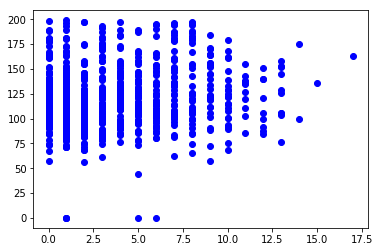

In [8]:
data = db_pid.datos
plt.plot(data[:,0], data[:,1], 'bo')

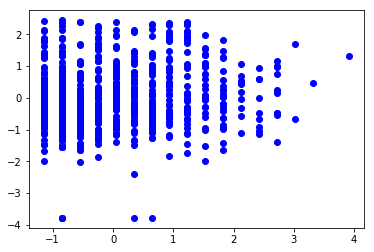

In [9]:
db_pid.normalizarDatos(db_pid.datos, db_pid.nominalAtributos)
data = db_pid.datos
plt.plot(data[:,0], data[:,1], 'bo')

Vamos a ver que la normalización es correcta

In [10]:
from sklearn import preprocessing

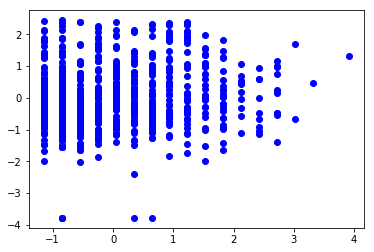

In [11]:
db_pid2 = Datos('../ConjuntosDatos/pima-indians-diabetes.data')

X_norm = preprocessing.scale(db_pid2.datos[:,:-1])

plt.plot(X_norm[:,0], X_norm[:,1], 'bo')

Vemos que las dos gráficas coinciden, indicándonos que, al menos para estos dos atributos, hemos normalizado correctamente

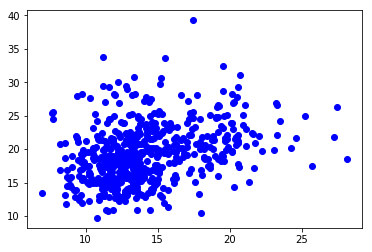

In [12]:
data = db_wdbc.datos
plt.plot(data[:,0], data[:,1], 'bo')

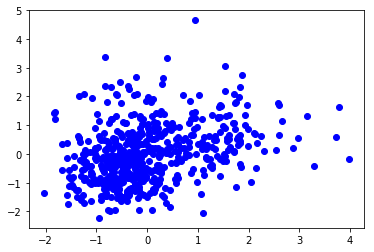

In [13]:
db_wdbc.normalizarDatos(db_wdbc.datos, db_wdbc.nominalAtributos)
data = db_wdbc.datos
plt.plot(data[:,0], data[:,1], 'bo')

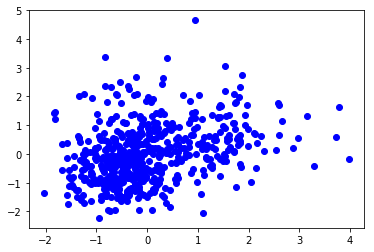

In [14]:
db_wdbc2 = Datos('../ConjuntosDatos/wdbc.data')

X_norm = preprocessing.scale(db_wdbc.datos[:,:-1])

plt.plot(X_norm[:,0], X_norm[:,1], 'bo')

De nuevo, las dos gráficas son iguales (la primera usando nuestras funciones de normalización y la segunda usando los métodos de sklearn). Ya estamos mucho más seguros de que nuestros métodos están bien implementados.

# <font color='red'>1. Vecinos próximos</font>


En las primeras fases de ejecución de este algoritmo fijaremos K=5 y variaremos la distancia utilizada para hacer unos primeros comentarios. Para terminar la sección ejecutaremos el algoritmo con todos los valores de K a analizar y todas las distancias posibles, escogiendo la mejor pareja de hiperparámetros para ambos conjuntos de entrenamiento.

## <font color='blue'> 1.1 Dataset pima-indians-diabetes </font>

Inicializamos los conjuntos de entrenamiento (uno normalizado y el otro no), así como las 3 estrategias de particionado que vamos a analizar:
   - Particionado simple (80% train - 20% test).
   - Particionado simple (80% train - 20% test) con 7 repeticiones.
   - Validación cruzada con 5 folds.

In [131]:
db_pid_notNorm = Datos('../ConjuntosDatos/pima-indians-diabetes.data', normalize=False)
print(db_pid_notNorm.datos.shape)

(768, 9)


In [132]:
db_pid_norm = Datos('../ConjuntosDatos/pima-indians-diabetes.data', normalize=True)
print(db_pid_norm.datos.shape)

(768, 9)


Como tenemos pocos ejemplos de entrenamiento (<1000) vamos a escoger un porcentaje alto para el particionado simple (~80%)

In [133]:
strat_simple = EstrategiaParticionado.ValidacionSimple(0.8)
strat_simple_rep7 = EstrategiaParticionado.ValidacionSimple(0.8, nreps=7)
strat_cross_f5 = EstrategiaParticionado.ValidacionCruzada(k_fold=5)

### 1.1.1 Distancia euclídea con datos sin normalizar

In [134]:
KNN_eucl = Clasificador.ClasificadorVecinosProximos(K=5, dist='euclidean')

Ejecutamos con validación simple.

In [140]:
errores = clasificador.validacion(strat_simple, db_pid_notNorm, KNN_eucl)
print('Error cometido:', errores)

Error cometido: [0.27922077922077926]


El error resultante con K=5, utilizando la distancia euclidea y con los datos SIN normalizar se concentra entre 25-32 %. Es aún pronto para hablar, esperemos a ver los resultados con otra estrategia de particionado (por ejemplo, simple con varias repeticiones) para tener una mejor estimación del error cometido.

Ejecutamos ahora varias repeticiones del particionado simple.

In [141]:
errores = clasificador.validacion(strat_simple_rep7, db_pid_notNorm, KNN_eucl)
print('Error medio', np.mean(errores), '+-', np.std(errores))

Error medio 0.28478664192949904 +- 0.02675733785130977


Vemos que el error medio con K=5, utilizando la distancia euclidea y con los datos SIN normalizar se concentra entre 25-28%. La desviación típica es pequeña. Será interesante comparar estos resultados con los datos normalizados.

Ejecutamos ahora el mismo modelo pero con un particionado cruzado

In [142]:
errores = clasificador.validacion(strat_cross_f5, db_pid_notNorm, KNN_eucl)
print('Error medio', np.mean(errores), '+-', np.std(errores))

Error medio 0.27712418300653596 +- 0.045583256925915555


Tras utilizar validación cruzada podemos ratificar que el error con K=5, utilizando la distancia euclidea y con los datos SIN normalizar se concentra entre 25-28%. Veamos ahora que pasa si normalizamos los datos.


### 1.1.2 Distancia euclídea con datos normalizados

In [147]:
errores = clasificador.validacion(strat_simple, db_pid_norm, KNN_eucl)
print('Error cometido:', errores)

Error cometido: [0.2532467532467533]


El error resultante con K=5, utilizando la distancia euclidea y con los datos normalizados se concentra entre 22-27%. De primeras sí que parece que es beneficioso normalizar los datos. Hagámoslo con varias repeticiones.

In [150]:
errores = clasificador.validacion(strat_simple_rep7, db_pid_norm, KNN_eucl)
print('Error medio', np.mean(errores), '+-', np.std(errores))

Error medio 0.2569573283858998 +- 0.02107201612541846


El error medio ha mejorado ligeramente tras normalizar los datos. Ahora parece que se concentra entre el 23-27%

In [154]:
errores = clasificador.validacion(strat_cross_f5, db_pid_norm, KNN_eucl)
print('Error medio', np.mean(errores), '+-', np.std(errores))

Error medio 0.25882352941176473 +- 0.035221421138058755


Ratificamos con validación cruzada lo dicho anteriormente. En este conjunto de entrenamiento la normalización de los datos mejora ligeramente el rendimiento del modelo.

Analicemos ahora los resultados con otras distancias.

### 1.1.3 Distancia de Manhattan con datos sin normalizar

In [155]:
KNN_manh = Clasificador.ClasificadorVecinosProximos(K=5, dist='manhattan')

Ejecutamos primero con particionado simple

In [168]:
errores = clasificador.validacion(strat_simple, db_pid_notNorm, KNN_manh)
print('Error cometido:', errores)

Error cometido: [0.2532467532467533]


A primera vista parece que la distancia de Manhattan funciona mejor para clasificar este conjunto de entrenamiento. De todas formas la evidencia estadística es prácticamente nula al haberlo ejecutado una sola vez. Esperemos para hablar.

In [161]:
errores = clasificador.validacion(strat_simple_rep7, db_pid_notNorm, KNN_manh)
print('Error medio', np.mean(errores), '+-', np.std(errores))

Error medio 0.2625231910946197 +- 0.028167396012409963


Tras repetirlo varias veces parece que la distancia de Manhattan mejora la precisión por un 0.01%. Esta diferencia es ínfima, puede haber sido simplemente en esta ejecución, pero será algo que deberemos prestar atención en las futuras secciones cuando escojamos los mejores hiperparámetros.

Ejecutamos ahora con validación cruzada.

In [162]:
errores = clasificador.validacion(strat_cross_f5, db_pid_notNorm, KNN_manh)
print('Error medio', np.mean(errores), '+-', np.std(errores))

Error medio 0.2666666666666666 +- 0.01867040112037345


Error medio muy parecido al anterior. Lo que hemos dicho se mantiene. Ahora nuestro objetivo principal será discernir si conviene o no normalizar los datos.

### 1.1.4 Distancia de Manhattan con datos normalizados

Como siempre, primero con particionado simple.

In [166]:
errores = clasificador.validacion(strat_simple, db_pid_norm, KNN_manh)
print('Error cometido:', errores)

Error cometido: [0.24675324675324672]


A primera vista parece que la diferencia entre normalizar los datos y no hacerlo es ínfima. Ejecutémoslo varias veces para poder hablar con más fundamento.

In [167]:
errores = clasificador.validacion(strat_simple_rep7, db_pid_norm, KNN_manh)
print('Error medio', np.mean(errores), '+-', np.std(errores))

Error medio 0.26623376623376627 +- 0.032188036313353395


El error vuelve a ser menor que con los datos sin normalizar, pero la diferencia es ínfima. Esto puede ser debido a que los datos originales ya eran fácilmente separables.

Veamos el rendimiento con valiación cruzada.

In [111]:
errores = clasificador.validacion(strat_cross_f5, db_pid_norm, KNN_manh)
print('Error medio', np.mean(errores), '+-', np.std(errores))

Error medio 0.269281045751634 +- 0.04203381749232295


El resultado medio sigue concentrándose entorno al 26%, y sigue siendo muy parecido a los resultados con los datos sin normalizar.

Ahora estudiaremos la distancia de Mahalanobis.

### 1.1.5 Distancia de Mahalanobis con datos sin normalizar

In [169]:
KNN_maha = Clasificador.ClasificadorVecinosProximos(K=5, dist='mahalanobis')

Empecemos como siempre por un particionado simple

In [174]:
errores = clasificador.validacion(strat_simple, db_pid_notNorm, KNN_maha)
print('Error cometido:', errores)

Error cometido: [0.27922077922077926]


Parece que la distancia de Mahalanobis tiene un rendimiento similar al modelo que usa la distancia euclídea. Aún es pronto para hablar ya que no tenemos evidencia estadística suficiente.

In [175]:
errores = clasificador.validacion(strat_simple_rep7, db_pid_notNorm, KNN_maha)
print('Error medio', np.mean(errores), '+-', np.std(errores))

Error medio 0.2625231910946197 +- 0.04769929548119647


Tras ejecutarlo varias veces podemos ver que el rendimiento es efectivamente similar al del modelo que usa la distancia euclidea. Vamos a realizar ahora una prueba con validación cruzada.

In [177]:
errores = clasificador.validacion(strat_cross_f5, db_pid_notNorm, KNN_maha)
print('Error medio', np.mean(errores), '+-', np.std(errores))

Error medio 0.265359477124183 +- 0.056315448963498084


Tras estos resultados, vamos a estudiar el impacto de normalizar los datos o no en este dataset.

### 1.1.6 Distancia de Mahalanobis con datos normalizados

In [181]:
errores = clasificador.validacion(strat_simple, db_pid_norm, KNN_maha)
print('Error cometido:', errores)

Error cometido: [0.2272727272727273]


Este resultado no difiere demasiado de los que llevamos obteniendo hasta el momento. Ahora vamos a ejecutar esto mismo varias veces.

In [183]:
errores = clasificador.validacion(strat_simple_rep7, db_pid_norm, KNN_maha)
print('Error medio', np.mean(errores), '+-', np.std(errores))

Error medio 0.25139146567717996 +- 0.028136829105942663


Vemos que el error cometido es ligeramente inferior al cometido con los datos sin normalizar. La distancia de mahalanobis aporta resultados también similares a los obtenidos con la distancia euclídea. Por ahora parece que la distancia de Manhattan es la más eficaz. Esto se analizará próximamente con más precisión.

In [185]:
errores = clasificador.validacion(strat_cross_f5, db_pid_norm, KNN_maha)
print('Error medio', np.mean(errores), '+-', np.std(errores))

Error medio 0.26143790849673204 +- 0.027106459285395703


De nuevo, el error es similar a los casos anteriores.

A lo largo de esta sección nos hemos preocupado por tomar contacto con las distintas distancias en el algoritmo de vecinos próximos. En el siguiente subapartado veremos qué distancia y qué número de vecinos K es el más preciso.

Ahora nos centramos en comentar los resultados de este conjunto de entrenamiento normalizado y sin normalizar. A lo largo de la sección hemos visto que los resultados obtenido, al menos para este dataset, son muy parecidos. Esto es debido a que los datos ya eran fácilmente separables en su espacio de definición original. Sin embargo, es bien conocido que normalizar los datos es recomendable cuando usamos el modelo de vecinos próximos por lo visto en el capítulo 0.

Debido a que los resultados son similares con ambos conjuntos de entramiento (pima-indians-diabetes normalizado y sin normalizar), vamos a escoger una de sus formas (normalizado) para discernir qué hiperparámetros son los mejores.

### <font color='green'> 1.1.7 Resultados y selección de hiperparámetros </font>

En las subsecciones anteriores vimos que no existía una gran diferencia entre las estrategias de particionado utilizadas. Para escoger los mejores hiperparámetros vamos a utilizar validación cruzada (5 folds), por su robustez de resultados y por ser de las más utilizadas en la cultura del aprendizaje automático.

In [186]:
Ks = [1, 5, 11, 21]
dists = ['euclidean', 'manhattan', 'mahalanobis']

In [187]:
strat = EstrategiaParticionado.ValidacionCruzada(k_fold=5)

+---------------+----------+----------+----------+----------+
| distancia/K   |        1 |        5 |       11 |       21 |
+===============+==========+==========+==========+==========+
| euclidean     | 0.294118 | 0.269281 | 0.257516 | 0.258824 |
+---------------+----------+----------+----------+----------+
| manhattan     | 0.318954 | 0.253595 | 0.270588 | 0.24183  |
+---------------+----------+----------+----------+----------+
| mahalanobis   | 0.299346 | 0.266667 | 0.264052 | 0.265359 |
+---------------+----------+----------+----------+----------+


[]

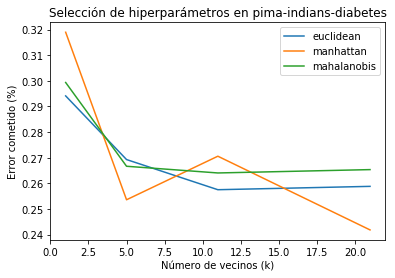

In [235]:
L = []
for d in dists:
    distance_results = []
    for k in Ks:
        KNN = Clasificador.ClasificadorVecinosProximos(K=k, dist=d)
        errores = clasificador.validacion(strat, db_pid_norm, KNN)
        err = np.mean(errores)
        distance_results.append(err)
    L.append([d]+distance_results)
    plt.plot(Ks, distance_results, label=d)

print(tabulate(L, headers=['distancia/K']+Ks, tablefmt="grid"))

plt.xlabel('Número de vecinos (k)')
plt.ylabel('Error cometido (%)')
plt.legend(loc='upper right')
plt.title('Selección de hiperparámetros en pima-indians-diabetes')
plt.plot()

Ejecutando la celda anterior varias veces podemos ver que, por lo general, la distancia que mejor rendimiento aporta es la distancia de Manhattan. A veces obtenemos que la distancia euclídea es la que tiene mejor precisón, pero en menos ocasiones.

Lo que está siempre claro es que el número de vecinos óptimos en la lista a analizar es k=21.

Comentar finalmente que no es de extrañar que la mejor distancia sea la de Manhattan, ya que en este dataset ciertos atributos tienen una relación lineal. Véase la siguiente celda como ejemplo.

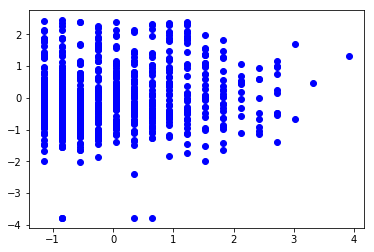

In [198]:
plt.plot(db_pid_norm.datos[:,0], db_pid_norm.datos[:,1], 'bo')

Concluimos esta sección ratificando los mejores resultados:
- Es **recomendable**, aunque no indispensable en este dataset, **normalizar** los datos.
- Sin duda, el mejor **número de vecinos** entre los analizados es **k=21**.
- La **distancia** que generalmente aporta mejores resultados es la **distancia de Manhattan**. En menor medida, también es aceptable la **distancia euclídea**.

## <font color='blue'> 1.2 Dataset WDBC </font>

Estudiamos ahora el algoritmo de Vecinos Próximos con un nuevo conjunto de entrenamiento: WDBC.

Como antes, analizamos dos conjuntos de entrenamiento (uno normalizado y el otro no), así como las 3 estrategias de particionado siguientes:
   - Particionado simple (80% train - 20% test).
   - Particionado simple (80% train - 20% test) con 7 repeticiones.
   - Validación cruzada con 5 folds.
   
Adicionalmente, volvemos a centrarnos en comprender el comportamiento de las distancias con los distintos datos, sin variar el número de vecinos, fijándolo a k=5.

In [199]:
db_wdbc_notNorm = Datos('../ConjuntosDatos/wdbc.data', normalize=False)
print(db_wdbc_notNorm.datos.shape)

(569, 31)


In [200]:
db_wdbc_norm = Datos('../ConjuntosDatos/wdbc.data', normalize=True)
print(db_wdbc_norm.datos.shape)

(569, 31)


### 1.2.1 Distancia euclídea con datos sin normalizar

In [213]:
errores = clasificador.validacion(strat_simple, db_wdbc_notNorm, KNN_eucl)
print('Error cometido:', errores)

Error cometido: [0.07017543859649122]


El error cometido parece que se concentra, con k=5, distancia euclídea y datos sin normalizar, entorno al 7%. Repitámoslo varias veces.

In [207]:
errores = clasificador.validacion(strat_simple_rep7, db_wdbc_notNorm, KNN_eucl)
print('Error medio', np.mean(errores), '+-', np.std(errores))

Error medio 0.07894736842105265 +- 0.018159619982693536


Ratificamos lo dicho anteriormente, el error se concentra cerca del 7%. Esperamos ahora a ver los resultados con los datos normalizados para comparar.

In [210]:
errores = clasificador.validacion(strat_cross_f5, db_wdbc_notNorm, KNN_eucl)
print('Error medio', np.mean(errores), '+-', np.std(errores))

Error medio 0.06194690265486724 +- 0.009694204557613575


Con validación cruzada obtenemos resultados similares.

Ahora veamos qué resultados conseguimos normalizando los datos.

### 1.2.2 Distancia euclídea con datos normalizados

In [220]:
errores = clasificador.validacion(strat_simple, db_wdbc_norm, KNN_eucl)
print('Error cometido:', errores)

Error cometido: [0.03508771929824561]


Parece que el error cometido ha bajado un 50%, es decir, el error con el conjunto de datos normalizado se concentra entorno al 3%. Repitamos esto varias veces.

In [222]:
errores = clasificador.validacion(strat_simple_rep7, db_wdbc_norm, KNN_eucl)
print('Error medio', np.mean(errores), '+-', np.std(errores))

Error medio 0.03759398496240602 +- 0.009036469362065164


Efectivamente, existe evidencia estadística de que el error ha bajado considerablemente normalizando los datos. Parece que este conjunto de entrenamiento es difícilmente separable en su soporte de definición y que traslandándolo y escalándolo por su media y desviación típica se puede separar con mayor facilidad.

In [223]:
errores = clasificador.validacion(strat_cross_f5, db_wdbc_norm, KNN_eucl)
print('Error medio', np.mean(errores), '+-', np.std(errores))

Error medio 0.03539823008849559 +- 0.014808142062549993


La ejecución usando validación cruzada nos confirma lo dicho hasta ahora: normalizar los datos es importante.

En las próximas subsecciones seguiremos analizando la importancia de normalizar los datos, junto con la comparación de rendimientos usando diferentes distancias.

### 1.2.3 Distancia de Manhattan con datos sin normalizar

Empezamos usando una estrategia de particionado simple

In [226]:
errores = clasificador.validacion(strat_simple, db_wdbc_notNorm, KNN_manh)
print('Error cometido:', errores)

Error cometido: [0.07017543859649122]


El error parece que se sigue concentrando en 7% con la distancia de Manhattan. Habrá que esperar a futuras secciones para tener un argumento contundente sobre qué distancia es mejor.

In [225]:
errores = clasificador.validacion(strat_simple_rep7, db_wdbc_notNorm, KNN_manh)
print('Error medio', np.mean(errores), '+-', np.std(errores))

Error medio 0.07518796992481203 +- 0.02429914715496906


Ratificamos los dicho, se sigue concentrando entorno al 7%

In [227]:
errores = clasificador.validacion(strat_cross_f5, db_wdbc_notNorm, KNN_manh)
print('Error medio', np.mean(errores), '+-', np.std(errores))

Error medio 0.06194690265486726 +- 0.017699115044247784


La validación cruzada parece que es una estrategia a seguir para conseguir mejores resultados.

### 1.2.4 Distancia de Manhattan con datos normalizados

Empezamos usando una estrategia de particionado simple

In [242]:
errores = clasificador.validacion(strat_simple, db_wdbc_norm, KNN_manh)
print('Error cometido:', errores)

Error cometido: [0.03508771929824561]


Con la distancia de Manhattan también se obtienen mejores resultados si normalizamos los datos. Repitámoslo más veces.

In [244]:
errores = clasificador.validacion(strat_simple_rep7, db_wdbc_norm, KNN_manh)
print('Error medio', np.mean(errores), '+-', np.std(errores))

Error medio 0.033834586466165405 +- 0.012779497527801451


Seguimos obteniendo un error concentrado en el 3%.

In [245]:
errores = clasificador.validacion(strat_cross_f5, db_wdbc_norm, KNN_manh)
print('Error medio', np.mean(errores), '+-', np.std(errores))

Error medio 0.03539823008849559 +- 0.007915284876105414


El error vuelve a ser del 3% con validación cruzada. Analizamos ahora la distancia de Mahalanobis.


### 1.2.5 Distancia de Mahalanobis con datos sin normalizar

Empezamos usando una estrategia de particionado simple

In [249]:
errores = clasificador.validacion(strat_simple, db_wdbc_notNorm, KNN_maha)
print('Error cometido:', errores)

Error cometido: [0.1578947368421053]


Podemos ver en un primer momento que la distancia de Mahalanobis aporta peores resultados que las dos anteriores. Es pronto para hablar, por loque lo vamos a ejecutar varias veces.

In [250]:
errores = clasificador.validacion(strat_simple_rep7, db_wdbc_notNorm, KNN_maha)
print('Error medio', np.mean(errores), '+-', np.std(errores))

Error medio 0.19172932330827067 +- 0.03644872073245359


Pues efectivamente, la distancia de Mahalanobis tiene un rendimiento pésimo en este dataset comparado con las dos anteriores. ¿Será culpa del normalizado de datos? Lo veremos en la próxima subsección.

In [251]:
errores = clasificador.validacion(strat_cross_f5, db_wdbc_notNorm, KNN_maha)
print('Error medio', np.mean(errores), '+-', np.std(errores))

Error medio 0.20176991150442483 +- 0.043856678560580085


Vemos que la validación cruzada no hace milagros.

### 1.2.6 Distancia de Mahalanobis con datos normalizados

Empezamos usando una estrategia de particionado simple

In [254]:
errores = clasificador.validacion(strat_simple, db_wdbc_norm, KNN_maha)
print('Error cometido:', errores)

Error cometido: [0.1578947368421053]


Parece que la normalización de datos no era el problema principal. Ejecutémoslo varias veces.

In [256]:
errores = clasificador.validacion(strat_simple_rep7, db_wdbc_norm, KNN_maha)
print('Error medio', np.mean(errores), '+-', np.std(errores))

Error medio 0.19924812030075187 +- 0.03436418346065684


Como era de esperar, la distancia de Mahalanobis sigue siendo el problema principal. Vemos que desde luego no la usaríamos para entrenar este conjunto de datos.

In [257]:
errores = clasificador.validacion(strat_cross_f5, db_wdbc_norm, KNN_maha)
print('Error medio', np.mean(errores), '+-', np.std(errores))

Error medio 0.1752212389380531 +- 0.04240406566623343


La validacón cruzada solo ratifica lo visto anteriormente.

Vamos a fijar la estrategia de particionado de validación cruzada ya que no existen grandes diferencias entre ellas. Adicionalmente, para seleccionar los mejores hiperparámetros, vamos a utilizar el conjunto de datos normalizado ya que es obvio que aporta un mejor rendimiento al modelo.

### <font color='green'> 1.2.7 Resultados y selección de hiperparámetros </font>

+---------------+-----------+-----------+-----------+-----------+
| distancia/K   |         1 |         5 |        11 |        21 |
+===============+===========+===========+===========+===========+
| euclidean     | 0.0371681 | 0.0318584 | 0.0318584 | 0.0460177 |
+---------------+-----------+-----------+-----------+-----------+
| manhattan     | 0.0424779 | 0.0353982 | 0.0389381 | 0.0513274 |
+---------------+-----------+-----------+-----------+-----------+
| mahalanobis   | 0.169912  | 0.19115   | 0.215929  | 0.293805  |
+---------------+-----------+-----------+-----------+-----------+


[]

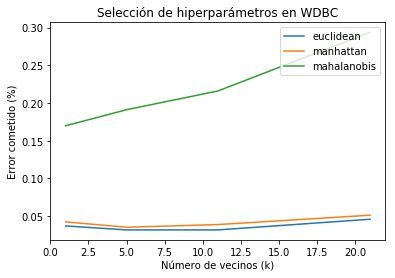

In [259]:
L = []
for d in dists:
    distance_results = []
    for k in Ks:
        KNN = Clasificador.ClasificadorVecinosProximos(K=k, dist=d)
        errores = clasificador.validacion(strat, db_wdbc_norm, KNN)
        err = np.mean(errores)
        distance_results.append(err)
    L.append([d]+distance_results)
    plt.plot(Ks, distance_results, label=d)

print(tabulate(L, headers=['distancia/K']+Ks, tablefmt="grid"))

plt.xlabel('Número de vecinos (k)')
plt.ylabel('Error cometido (%)')
plt.legend(loc='upper right')
plt.title('Selección de hiperparámetros en WDBC')
plt.plot()

Ejecutando la celda anterior varias veces podemos ver que, por lo general, la distancia euclidea y de Manhattan son las que mejor rendimiento aportan. Por lo general, la distancia euclídea es ligeramente mejor que la de Manhattan. Lo que esta clarísimo, es que la distancia de Mahalanobis no es adecuada para entrenar este dataset.

Por otro lado, el número de vecinos (k) óptimo es o 5 u 11, con resultados muy similares. Por lo general, k=1 y k=21 tienen peores resultados. Como para k=5 y k=11 los resultados son tan parecidos, podríamos escoger cualquiera de los dos valores.

Comentar finalmente que no es de extrañar que los datos normalizados aporten mejores resultados. Este conjunto de entrenamiento tenían grandes diferencias de escala entre sus atributos y la normalización permite que todos ellos se definan en un espacio más homogéneo, permitiendonos trabajar mejor con las distancias y obtener una precisión mayor.

Concluimos esta sección ratificando los mejores resultados:
- Es **importante** **normalizar** los datos de este conjunto.
- El mejor **número de vecinos** entre los analizados es **k=5** ó **k=11**.
- La **distancia** que generalmente aporta mejores resultados es la **distancia de euclídea**, aunque la **distancia de Manhattan** también aporta resultados similares.

# <font color='red'>2. Regresión Logística</font>

In [20]:
KNNSK = Clasificador.ClasificadorVecinosProximosSK(K=5, dist='euclidean')

In [21]:
errores = clasificador.validacion(strat_simple, db_pid, KNNSK)
print(errores)

[0.27922077922077926]


In [22]:
db_wdbc = Datos('../ConjuntosDatos/wdbc.data', normalize=True)
ndata, ncols = db_wdbc.datos.shape
print(ndata, ncols)

569 31


In [23]:
errores = clasificador.validacion(strat_simple, db_wdbc, KNN)
print(errores)

[0.02631578947368418]


In [24]:
errores = clasificador.validacion(strat_simple, db_wdbc, KNNSK)
print(errores)

[0.03508771929824561]


## Regresión Logística

In [70]:
db_pid = Datos('../ConjuntosDatos/pima-indians-diabetes.data', normalize=True)
ndata, ncols = db_pid.datos.shape
print(ndata, ncols)

768 9


In [85]:
RL = Clasificador.ClasificadorRegresionLogistica(learning_rate=0.5, nepochs=110)

In [86]:
errores = clasificador.validacion(strat_simple, db_pid, RL)
print(errores)

[0.2727272727272727]


In [87]:
RL.W

array([-0.42988504,  0.45718747,  2.25871354, -0.04090096, -0.62269832,
       -1.35585374,  1.37867623,  1.29336895,  1.53931028])

In [92]:
RL_SKLR = Clasificador.ClasificadorRegresionLogisticaSK(learning_rate=0.5, sgd=False)

In [93]:
errores = clasificador.validacion(strat_simple, db_pid, RL_SKLR)
print(errores)

[0.23376623376623373]


In [104]:
RL_SKSGD = Clasificador.ClasificadorRegresionLogisticaSK(learning_rate=0.5, sgd=True)

In [105]:
errores = clasificador.validacion(strat_simple, db_pid, RL_SKSGD)
print(errores)

[0.2597402597402597]


In [65]:
db_wdbc = Datos('../ConjuntosDatos/wdbc.data', normalize=True)
ndata, ncols = db_wdbc.datos.shape
print(ndata, ncols)

569 31


In [66]:
errores = clasificador.validacion(strat_simple, db_wdbc, RL)
print(errores)

[0.02631578947368418]


In [120]:
errores = clasificador.validacion(strat_simple, db_wdbc, RL_SKLR)
print(errores)

[0.03508771929824561]


In [121]:
errores = clasificador.validacion(strat_simple, db_wdbc, RL_SKSGD)
print(errores)

[0.02631578947368418]


# <font color='red'>4. Análisis ROC </font>

In [3]:
def create_confMatrix(pred, real):
    i = 0
    tp, fp, tn, fn = 0, 0, 0, 0
    
    for pred_val in pred:
        # True negative
        if pred_val==0 and pred_val==real[i]:
            tn += 1
        # False negative
        elif pred_val==0 and pred_val!=real[i]:
            fn += 1
        # True positive
        elif pred_val==1 and pred_val==real[i]:
            tp += 1
        # False positive
        elif pred_val==1 and pred_val!=real[i]:
            fp += 1
        i += 1
    
    return [['PRED POS', tp, fp], ['PRED NEG', fn, tn]]




def print_confMatrix(m):
    headers = ["", "REAL POS", "REAL NEG"]
    print(tabulate(m, headers, tablefmt="grid")) 

In [6]:
def ROC_Analysis(dataset, clf, particionado, print_confMtx=True):
    seed = random.seed(0)
    np.random.shuffle(dataset.datos)
    particionado.creaParticiones(dataset.datos, seed)
    
    TPRs = [] # True positive ratios
    FPRs = [] # False positive ratios
    for particion in particionado.particiones:

        datostrain = dataset.datos[particion.indicesTrain, :]
        datostest = dataset.datos[particion.indicesTest, :]
            
        clf.entrenamiento(datostrain, dataset.nominalAtributos, dataset.diccionario)
            
        pred = clf.clasifica(datostest, dataset.nominalAtributos, dataset.diccionario)
        real = datostest[:,-1] 
        
        # Creating confusion matrix, calculating TPR and FPR.
        m = create_confMatrix(pred, real)
        tpr_aux = m[0][1]/(m[0][1] + m[1][1])
        fpr_aux = m[0][2]/(m[0][2] + m[1][2])
        TPRs.append(tpr_aux)
        FPRs.append(fpr_aux)
    
    # Calculating TPRs and FPRs mean
    tpr = np.mean(TPRs)
    fpr = np.mean(FPRs)
    
    # Printing confusion matrix (if we want to)
    if print_confMtx:
        print_confMatrix(m)
        print("Punto espacio ROC: (", fpr, ",", tpr, ")")

    return fpr, tpr
 

In [23]:
def plot_ROC(fpr, tpr, clf_name=None, dataset_name=None):
    plt.figure()
    
    rand_bins = np.linspace(0, 1, num=30)
    plt.plot(rand_bins, rand_bins, color='blue', linestyle='dashed', label='random clf')
    
    tpr_coords = [0, tpr, 1]
    fpr_coords = [0, fpr, 1]
    plt.plot(fpr_coords, tpr_coords, color='red', label='classifier')
    
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.legend(loc='lower right')
    if clf_name:
        plt.title('ROC space for '+clf_name)
    if dataset_name:
        plt.suptitle('Dataset used: '+dataset_name)
    else:
        plt.title('ROC space')

## <font color='blue'> 4.1 Dataset pima-indians-diabetes </font>

In [13]:
db_pid = Datos('../ConjuntosDatos/pima-indians-diabetes.data')
db_pid_sk = Datos('../ConjuntosDatos/pima-indians-diabetes.data')

np.random.shuffle(db_pid.datos)
np.random.shuffle(db_pid_sk.datos)

KNN_eucl = Clasificador.ClasificadorVecinosProximos(K=5, dist='euclidean')
KNNSK = Clasificador.ClasificadorVecinosProximosSK(K=5, dist='euclidean')

In [15]:
strat_simple = EstrategiaParticionado.ValidacionSimple(0.8)

In [16]:
fpr_nb, tpr_nb = ROC_Analysis(db_pid, KNN_eucl, strat_simple)

+----------+------------+------------+
|          |   REAL POS |   REAL NEG |
+==========+============+============+
| PRED POS |         30 |         18 |
+----------+------------+------------+
| PRED NEG |         23 |         83 |
+----------+------------+------------+
Punto espacio ROC: ( 0.1782178217821782 , 0.5660377358490566 )


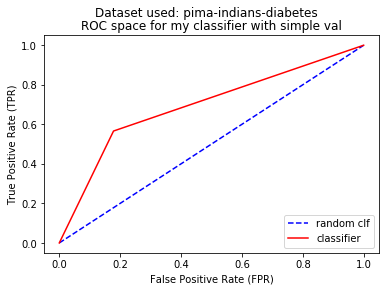

In [24]:
plot_ROC(fpr_nb, tpr_nb, clf_name='my classifier with simple val', dataset_name='pima-indians-diabetes')